In [21]:
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np

In [3]:
DATASET_DIR = "..\\.dataset"

In [ ]:
def load_dataset():
    data = {"train": [], "test": [], "valid": []}
    for country in os.listdir(DATASET_DIR):
        for data_type in os.listdir(os.path.join(DATASET_DIR, country)):
            for metadata in os.listdir(os.path.join(DATASET_DIR, country, data_type)):
                if metadata.endswith(".txt"):
                    with open(os.path.join(DATASET_DIR, country, data_type, metadata)) as f:
                        for line in f:
                            data_point = line.strip().split(" ")[-2:]
                            data_point = np.array([float(x) for x in data_point])
                            data[data_type].append(data_point)
    
    return np.array(data["train"]), np.array(data["valid"]), np.array(data["test"])


train, valid, test = load_dataset()


In [21]:
train.shape, valid.shape, test.shape

((1240, 2), (316, 2), (177, 2))

### We need to find the correct aspect ratio over all our datasets

In [56]:
data = np.concatenate((train, valid, test), axis=0)

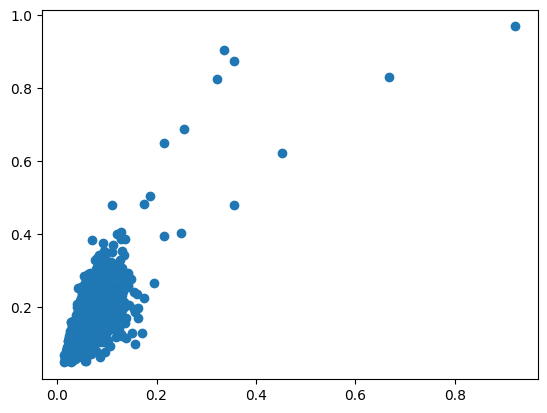

In [57]:
fig, ax = plt.subplots()
ax.scatter(data[:, 1], data[:, 0])
plt.show()

# Finding random centroids

In [58]:
def generate_random_centroids(data, k=1):
    centroids = map(lambda idx: np.random.choice(data[:, idx], size=k, replace=False), range(data.shape[1]))
    centroids = np.array(list(centroids))
    return centroids.T

In [59]:
centroids = generate_random_centroids(data, 5)
centroids

array([[0.2       , 0.05328571],
       [0.29334286, 0.0838    ],
       [0.18285714, 0.08194286],
       [0.28101706, 0.10191429],
       [0.10142857, 0.07728957]])

# Calculate IOU distance
This distance measurement is taken from YOLOv2 paper,
instead of euclidean distance we measure the IOU distance

In [70]:
def calculate_iou(box, centroid):
    # intersection area between boxes and centroids
    bnc_area = np.minimum(box[:, 0], centroid[0]) * np.minimum(box[:, 1], centroid[1])
    # union area of boxes and centroids
    buc_area = box[:, 0] * box[:, 1] + centroid[0] * centroid[1] - bnc_area

    iou = bnc_area/buc_area

    return iou

def calculate_iou_distance(box, centroid):
    return 1 - calculate_iou(box, centroid)


### We use get_labels to get the cluster of each data point

In [61]:
def get_labels(data, centroids):
    distances = np.array([calculate_iou_distance(data, centroid) for centroid in centroids])
    return np.argmin(distances, axis=0)

In [63]:
unique_clusters, frequency = np.unique(get_labels(data, centroids), return_counts=True)
unique_clusters, frequency

(array([0, 1, 2, 3, 4]), array([835, 162, 290, 139, 307]))

### Calculating geometric mean to find new centroids

In [97]:
def calc_geometric_mean(labels, data):
    unique_labels = np.unique(labels)
    if max(unique_labels) >= unique_labels.shape[0]:
        raise ValueError(f"Number of unique {unique_labels}")
    means = np.zeros((unique_labels.shape[0], data.shape[1]))
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        means[label, :] = [np.exp(np.mean(np.log(data[indices, idx]))) for idx in range(data.shape[1])] 

    return means

In [68]:
def plot_clusters(data, labels, centroids, iterations):
    clear_output(wait=True)
    plt.title(f"Iteration {iterations}")
    plt.scatter(x=data[:, 0], y=data[:, 1], c=labels)
    plt.scatter(x=centroids[:, 0], y=centroids[:, 1])
    plt.show()

### Calculate Average IOU

In [86]:
def calc_average_iou(data, labels,centroids):
    unique_labels = np.unique(labels)
    iou = np.array([])

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        cluster = data[indices, :]
        iou = np.concatenate((iou, calculate_iou(cluster, centroids[label])), axis=0)
    return np.mean(iou)

# Running our K-means algorithm for various values of k

In [117]:
def find_optimal_centroids(k, centroids, max_iterations=1):
    iteration = 1
    old_centroids = np.zeros(centroids.shape)

    while iteration < max_iterations and not np.all(old_centroids == centroids):
        if iteration == 1:
            labels = get_labels(data, centroids)
            if np.unique(labels).shape[0] < k:
                centroids = generate_random_centroids(data, k)
                continue

        old_centroids = centroids

        iteration = 1
        labels = get_labels(data, centroids)
        centroids = calc_geometric_mean(labels, data)

        iteration += 1
    return centroids


In [120]:
max_iterations = 1000
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15]


average_iou = np.zeros((len(k_values)))
for idx, k in enumerate(k_values):
    centroids = find_optimal_centroids(k, generate_random_centroids(data, k), max_iterations)
    
    labels = get_labels(data, centroids)
    average_iou[idx] = calc_average_iou(data, labels, centroids)

average_iou

array([0.58988954, 0.68132305, 0.72821759, 0.75725985, 0.77491472,
       0.7805078 , 0.79575632, 0.80441479, 0.81443097, 0.82230934,
       0.82539052, 0.83385631, 0.84273699, 0.84782915, 0.85112913])

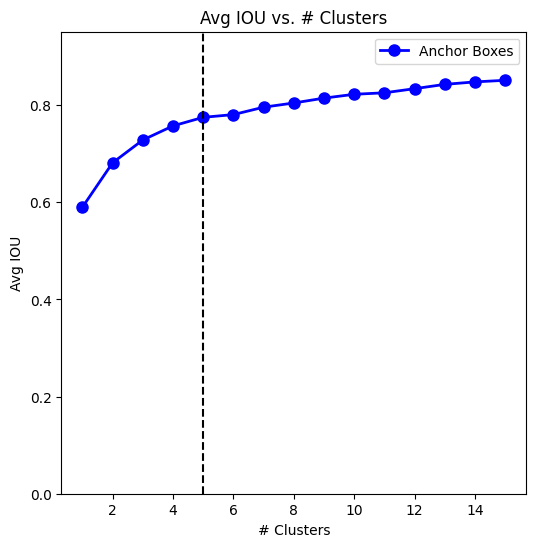

In [121]:
plt.figure(figsize=(6, 6))
plt.plot(k_values, average_iou, color='blue', label='Anchor Boxes', marker='o', markersize=8, linestyle='-', linewidth=2)
plt.axvline(x=5, color='k', linestyle='--')
plt.ylim(0, np.max(average_iou)+0.1)

plt.xlabel('# Clusters')
plt.ylabel('Avg IOU')
plt.title('Avg IOU vs. # Clusters')

plt.legend()
plt.show()

### Selecting centroids
Finally we select k=5 as our cluster as the curve change after 5 is small.

In [123]:
centroids = find_optimal_centroids(5, generate_random_centroids(data, 5), max_iterations)
centroids

array([[0.2451295 , 0.1225873 ],
       [0.2318253 , 0.07109304],
       [0.0892604 , 0.0282808 ],
       [0.16825111, 0.05899584],
       [0.13760775, 0.03984031]])